In [3]:
import numpy as np
import pandas as pd
import time
from scipy.io import wavfile
from skimage import util
from scipy import signal
from scipy import stats

#from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

#from sklearn.cluster import KMeans
#from sklearn.metrics.cluster import silhouette_score

#visualizing results
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#import yellowbrick as yb

In [4]:
file_path = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/USVs/CPA_pair_exp/18.12.07_CPA_pair_3x/535.wav'

In [7]:
def create_slice_from_wav(file_path, slice_len, step_size):
    """Creates small slices from wav file. Slice_len (use sampling frequency to convert to ms). 
    Step_size is amount of overlap between each slice."""
    
    #read in wav file
    samp_freq, sig_data = wavfile.read(file_path)
    print('Sampling frequency: ' + str(samp_freq))
    
    #determine number of samples and length
    n_samples = sig_data.shape[0]
    print('Number of samples: ' + str(n_samples))
    sig_len = n_samples/samp_freq
    print('Length: ' + str(sig_len) + ' sec')
    
    #create slices 
    M = slice_len
    steps = int(M*step_size)
    slices = util.view_as_windows(sig_data, window_shape=(M,), step=steps)
    print(f'Audio shape: {sig_data.shape}, Sliced audio shape: {slices.shape}')
    
    return samp_freq, sig_data, slices, steps

In [12]:
def plot_spec(Sx, times, steps, time_stamp):
    """Plots a spectrogram from a slice"""
    
    f, ax = plt.subplots()
    plt.pcolormesh((times*1000) + (time_stamp), freqs_spec / 1000, 10 * np.log10(Sx))
    ax.ticklabel_format(useOffset=False)
    plt.ylabel('Frequency [kHz]')
    plt.xlabel('Time [msec]')
    plt.show()
    
    return plt

Create slices from wav file

In [46]:
samp_freq, sig_data, slices, steps = create_slice_from_wav(file_path, 12500, 0.5)

Sampling frequency: 250000
Number of samples: 180748288
Length: 722.993152 sec
Audio shape: (180748288,), Sliced audio shape: (28918, 12500)


Create spectrogram from each slice (option to plot)

In [47]:
start = time.time()
spec_window = 128
NFFT = 256
samp_freq_kHz = samp_freq/1000
i = 0
spec_slices = {}
spec_slices_ravel = {}

for i in range(slices.shape[0]):
    
    #spectrogram
    freqs_spec, times, Sx = signal.spectrogram(slices[i,:], fs=samp_freq, nperseg = spec_window, nfft = NFFT)
    
    #psd
    #freqs_psd, Px = create_psd_from_slice(sli)
    
    #plot spectrogram
    #plt_spec = plot_spec(Sx, times, steps, i)
    
    #plot spd
    #plt_psd = plot_psd(Px, freqs_psd)
    
    time_stamp = i*steps / samp_freq_kHz
    
    spec_slices[time_stamp] = Sx
    spec_slices_ravel[time_stamp] = spec_slices[time_stamp].ravel().T
    
    #psd_slices[i] = np.log10(Px)
    #psd_slices_ravel[i] = Px[i].ravel().T
    
end = time.time()
print(end - start)

673.8877983093262


In [17]:
spec_slices_df = pd.DataFrame(spec_slices_ravel).T
spec_slices_df.head()

,0,1,2,3,4,5,6,7,8,9,...,28757,28758,28759,28760,28761,28762,28763,28764,28765,28766
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.034791,0.157594,0.029311,0.154757,0.025271,0.277930,0.088891,0.031531,0.048322,0.043249
50.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.082405,0.036593,0.106401,0.242589,0.012758,0.078751,0.040824,0.016307,0.014834,0.000645
100.0,1.385256,2.980197,36.400345,14.312963,23.864168,1.566864,12.290141,1.026281,32.817505,48.472214,...,0.008817,0.037948,0.169130,0.091708,0.099464,0.039362,0.032758,0.117893,0.003960,0.020596
150.0,0.083579,0.001476,0.529463,0.079701,0.013763,0.018957,0.004640,0.000028,0.188468,0.125065,...,0.063076,0.015227,0.036046,0.000057,0.024948,0.203080,0.005172,0.207238,0.007058,0.004882
200.0,0.180176,1.819653,0.034224,0.291076,2.933878,0.086449,0.075673,0.000282,1.937228,1.276914,...,0.002087,0.050329,0.099865,0.000478,0.146562,0.077276,0.037211,0.035421,0.004569,0.026114


Threshold data

In [ ]:
spec_slices_thresh_df = pd.DataFrame(index = spec_slices_df.index)
for time_stamp in spec_slices_df.index:
    threshold = np.percentile(spec_slices_df.loc[time_stamp], 70)
    spec_slices_thresh_df.loc[time_stamp][spec_slices_df.loc[time_stamp] < threshold] = 0
    
spec_slices_thresh_df.head()    

Find power sum of each spectrogram

In [ ]:
power_sum_df = pd.DataFrame(index = spec_slices_df.index, columns = ['time_stamp', 'power_sum'])
for time_stamp in spec_slices_df.index:
    power_sum_df.loc[time_stamp]['power_sum'] = spec_slices_df.loc[time_stamp].sum()
    power_sum_df.loc[time_stamp]['time_stamp'] = time_stamp
print(power_sum_df.shape)
power_sum_df.tail()

In [ ]:
plt.hist(power_sum_df['power_sum'].values)
plt.show()

Threshold on power sum

In [ ]:
threshold_power = np.percentile(power_sum_df['power_sum'].values, 99)
print(threshold_power)
power_sum_df_thresh = power_sum_df[power_sum_df['power_sum'] > threshold_power]
print(power_sum_df_thresh.shape)
power_sum_df_thresh.head()

Find spectral flatness of each spectrogram

In [30]:
spec_flat_df = pd.DataFrame(index = spec_slices_df.index, columns = ['time_stamp', 'spec_flat'])
for time_stamp in spec_slices_df.index:
    x = spec_slices_df.loc[time_stamp]
    spec_flat_df.loc[time_stamp]['spec_flat'] = (stats.gmean(x)) / (x.mean())
    spec_flat_df.loc[time_stamp]['time_stamp'] = time_stamp
print(spec_flat_df.shape)
spec_flat_df.tail()


(14458, 2)


,time_stamp,spec_flat
722650.0,722650,0.295947
722700.0,722700,0.375121
722750.0,722750,0.32302
722800.0,722800,0.28549
722850.0,722850,0.298806


KeyboardInterrupt: 

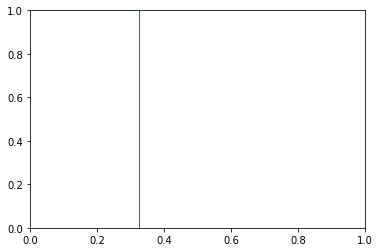

In [37]:
plt.hist(spec_flat_df['spec_flat'].values, bins = 10)
plt.show()

Threshold on spectral flatness

In [42]:
threshold_flat = np.percentile(spec_flat_df['spec_flat'].values, 1)
print(threshold_flat)
spec_flat_df_thresh = spec_flat_df[spec_flat_df['spec_flat'] < threshold_flat]
print(spec_flat_df_thresh.shape)
spec_flat_df_thresh.head()

0.02263098070397973
(145, 2)


,time_stamp,spec_flat
0.0,0,0
50.0,50,0
23450.0,23450,0.00941465
23500.0,23500,0.009945
30050.0,30050,0.0160146


In [35]:
spec_flat_df['spec_flat'].mean()

0.2637076737359939

In [43]:
#time_stamp_list_power = power_sum_df_thresh.index.values
time_stamp_list_flatness = spec_flat_df_thresh.index.values

In [44]:
import math
def facet_plot(image_df, time_stamp_list_flatness):
    plt.figure(figsize = (20,20))
    plot_row_num = math.ceil(math.sqrt(len(time_stamp_list_flatness)))
    plot_col_num = math.ceil(len(time_stamp_list_flatness) / plot_row_num)
    for idx, time_stamp in enumerate(time_stamp_list_flatness):
        plt.subplot(plot_row_num, plot_col_num, idx+1)
        plt.pcolormesh((times*1000) + (time_stamp), freqs_spec / 1000, 10 * np.log10(image_df[time_stamp]))
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


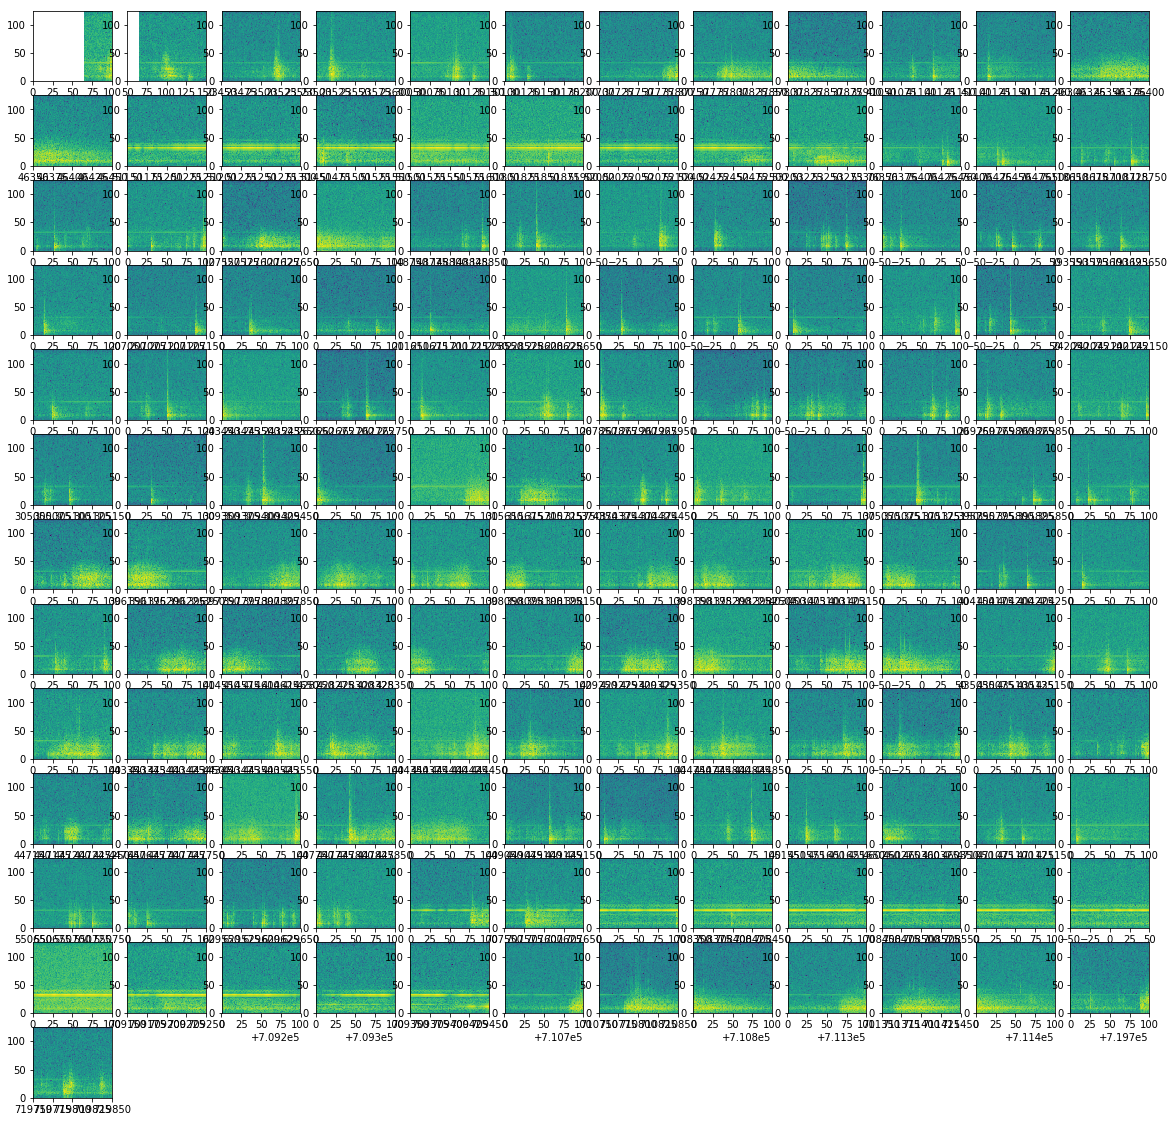

In [45]:
facet_plot(spec_slices, time_stamp_list_flatness)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30, whiten=True)
X_transformed = pca.fit_transform(np.log(spec_slices_df.iloc[2:]))

In [ ]:
spec_slices_df.iloc[2:].shape

In [ ]:
freq_count, time_count = spec_slices[50].shape
freq_count

In [ ]:
X_transformed[1]

In [ ]:
pca.components_.shape

In [ ]:
pca.explained_variance_ratio_

In [ ]:
plt.plot(pca.singular_values_)
plt.title("Singular values")

In [ ]:
u = pca.components_[:,:].reshape(30,-1,time_count)
plt.imshow(u[3])

In [ ]:
plt.figure(figsize = (10,10))
for i in range(30):
    plt.subplot(5,5,i+1)
    plt.imshow(u[i])

In [ ]:
# plot first ten components
plt.figure(figsize = (10,5))
m = 60
spec_dim = [60,59]
u = pca.components_[:,:].reshape(30,-1,m-1)
for i in range(10):
    plt.subplot(2,5,i+1)
    # we are rescaling between 0 and 1 before plotting
    plt.imshow((np.squeeze(np.flipud(u[i,:,:])-u.min()))/(u.max() - u.min()), vmin = 0, vmax = 1,cmap = 'viridis')
    #PlotSpecgram(u[i,:,:],freqs[:m],bins)
    plt.title('Mode '+str(i+1))

In [ ]:
# center and scale the data
scaler = StandardScaler()
slices_scaled = scaler.fit_transform(spec_slices_df)

In [ ]:
k_range = range(2,20)
scores = []
for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=1)
    km_ss.fit(slices_scaled)
    scores.append(silhouette_score(slices_scaled, km_ss.labels_))

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

In [ ]:
km2 = KMeans(n_clusters=3,random_state=1234)
km2.fit(slices_scaled)
score = silhouette_score(slices_scaled, km_ss.labels_)
#summary_ave['kmeans_2_scaled'] = [ "cluster_" + str(label) for label in km2.labels_ ]
#summary_ave.groupby('kmeans_2_scaled').mean()
print(score)